### Import Libraries

In [96]:
import pandas as pd
import random
import os
import numpy as np
from functools import partial
from lightgbm import LGBMRegressor
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [97]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [98]:
def dataset_split_X_y(df):    
    """
    @Description: split data into features and labels
    @Param: df, pandas dataframe with columns starting with X for features and Y for labels
    @Return: features and labels in pandas dataframes
    """
    xs = df.filter(regex='X') # Input : X Feature
    ys = df.filter(regex='Y') # Output : Y Feature
    return xs, ys

In [99]:
def zero_variance(df):
    """
    @Description: check for zero_variance
    @Param1: df, pandas dataframe
    @Return: names of the columns with zero variance
    """
    result = []
    for col in df.columns:
        if df[col].var() == 0:
            result.append(col)
    return result

In [100]:
def get_top_correlation(df, n=10):
    """
    @Description: print out top correlated features
    @Param1: df, pandas dataframe
    @Param2: n, number of lines to print 
    @Return: pandas series
    """
    pairs = set()
    for idx1 in range(0, df.shape[1]):
        for idx2 in range(0, idx1+1):
            pairs.add((df.columns[idx1], df.columns[idx2]))
    corr = df.corr().abs().unstack()
    corr = corr.drop(labels=pairs).sort_values(ascending=False)
    return corr[0:n]

In [101]:
def lg_nrmse(gt, preds):
    """
    @Description: Metric used in this project
    @Params1: gt, pandas dataframe
    @Param2: preds, pandas dataframe
    @Return: nrmse score
    """
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    preds = pd.DataFrame(preds)
    all_nrmse = []
    for idx in range(0,14):
        rmse = mean_squared_error(gt.iloc[:,idx], preds.iloc[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt.iloc[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:15])
    return score

In [102]:

train_df = pd.read_csv('data/train.csv')
test_x = pd.read_csv('data/test.csv')
train_x, train_y = dataset_split_X_y(train_df)

cols_with_zero_variance = zero_variance(train_x) # 분산이 0 (통과 여부)
train_x = train_x.drop(cols_with_zero_variance, axis = 1)
test_x = test_x.drop(cols_with_zero_variance, axis = 1)

train_x = train_x.drop(['X_10', 'X_11'], axis = 1) # 결측치가 많음 (결측치 = 0, 공지사항)
test_x = test_x.drop(['X_10', 'X_11'], axis = 1)

test_x = test_x.drop('ID', axis=1)

In [103]:
#Feature Selection

# 스크류 삽입 깊이 차이
train_x['X_57'] = (train_x['X_19'] + train_x['X_20'] + train_x['X_21'] + train_x['X_22'])/4

# 커넥터 핀 치수
train_x['X_58'] = (train_x['X_24'] + train_x['X_25'] + train_x['X_26'] + train_x['X_27'] + train_x['X_28'] + train_x['X_29'])/6

# 스크류 삽입 시 분당 회전 수
train_x['X_59'] = (train_x['X_34'] + train_x['X_35'] + train_x['X_36'] + train_x['X_37'])/4

# 하우징 PCB 안착부 치수
train_x['X_60'] = (train_x['X_38'] + train_x['X_39'] + train_x['X_40'])/3

# 레이돔 치수
train_x['X_61'] = (train_x['X_41'] + train_x['X_42'] + train_x['X_43'] + train_x['X_44'])/4

# RF 부분 SMT 납 량
train_x['X_62'] = (train_x['X_50'] + train_x['X_51'] + train_x['X_52'] + train_x['X_53'] + train_x['X_54'] + train_x['X_55'] + train_x['X_56'])/7



In [104]:
#Feature Selection

# 스크류 삽입 깊이 차이
test_x['X_57'] = (test_x['X_19'] + test_x['X_20'] + test_x['X_21'] + test_x['X_22'])/4

# 커넥터 핀 치수
test_x['X_58'] = (test_x['X_24'] + test_x['X_25'] + test_x['X_26'] + test_x['X_27'] + test_x['X_28'] + test_x['X_29'])/6

# 스크류 삽입 시 분당 회전 수
test_x['X_59'] = (test_x['X_34'] + test_x['X_35'] + test_x['X_36'] + test_x['X_37'])/4

# 하우징 PCB 안착부 치수
test_x['X_60'] = (test_x['X_38'] + test_x['X_39'] + test_x['X_40'])/3

# 레이돔 치수
test_x['X_61'] = (test_x['X_41'] + test_x['X_42'] + test_x['X_43'] + test_x['X_44'])/4

# RF 부분 SMT 납 량
test_x['X_62'] = (test_x['X_50'] + test_x['X_51'] + test_x['X_52'] + test_x['X_53'] + test_x['X_54'] + test_x['X_55'] + test_x['X_56'])/7



C:\Users\dlwl9\anaconda3\envs\dacon\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


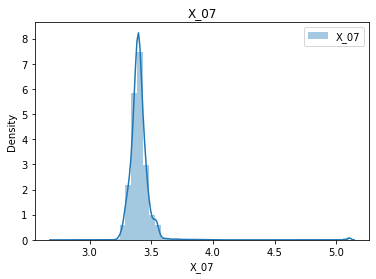

In [105]:
train_x["X_07"] = np.log1p(train_x["X_07"])
sns.distplot(train_x["X_07"],label="X_07")
plt.title('X_07')
#각 선에 라벨링 표기
plt.legend()
plt.show()

test_x["X_07"] = np.log1p(test_x["X_07"])

C:\Users\dlwl9\anaconda3\envs\dacon\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


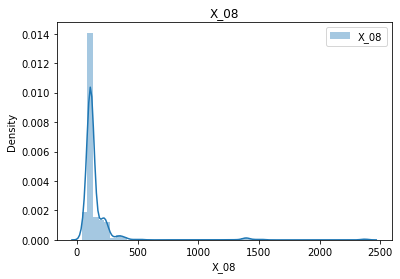

In [41]:
sns.distplot(train_x["X_08"],label="X_08")
plt.title('X_08')
#각 선에 라벨링 표기
plt.legend()
plt.show()


C:\Users\dlwl9\anaconda3\envs\dacon\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


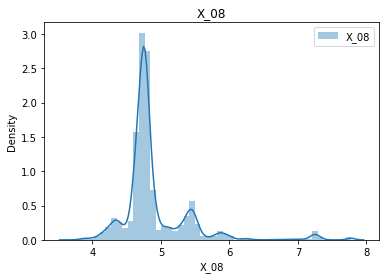

In [106]:
train_x["X_08"] = np.log1p(train_x["X_08"]+1)
sns.distplot(train_x["X_08"],label="X_08")
plt.title('X_08')
#각 선에 라벨링 표기
plt.legend()
plt.show()

test_x["X_08"] = np.log1p(test_x["X_08"]+1)


C:\Users\dlwl9\anaconda3\envs\dacon\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


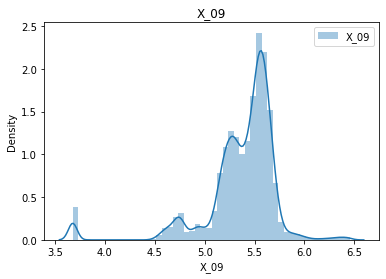

In [107]:
train_x["X_09"] = np.log1p(train_x["X_09"]+1)
sns.distplot(train_x["X_09"],label="X_09")
plt.title('X_09')
#각 선에 라벨링 표기
plt.legend()
plt.show()

test_x["X_09"] = np.log1p(test_x["X_09"]+1)

In [86]:
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'subsample': '{:.3f}'.format(params['subsample']),
        'min_split_gain': '{:.3f}'.format(params['min_split_gain']),
        'scale_pos_weight': '{:.3f}'.format(params['scale_pos_weight']),
        'reg_alpha': '{:.3f}'.format(params['reg_alpha']),
        'reg_lambda': '{:.3f}'.format(params['reg_lambda']),
        'learning_rate': '{:.3f}'.format(params['learning_rate']),
        
    }
    
    model = MultiOutputRegressor(LGBMRegressor(n_jobs = -1, random_state = 1, **params))
    
    loss = -cross_val_score(model, train_x, train_y, cv=10, scoring=make_scorer(lg_nrmse, greater_is_better=False)).mean()
    print("NRMSE Loss {:.5f} params {}".format(loss, params))
    return loss

In [87]:
space = {
    'n_estimators' : hp.quniform('n_estimators', 100, 1500, 50),
    'max_depth': hp.quniform('max_depth', 3, 100, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 100, 10),
    'min_child_samples': hp.quniform('min_child_samples', 10, 300, 10),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'subsample': hp.uniform('subsample', 0.3, 1.0),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.7),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10),
    'reg_alpha': hp.uniform('reg_alpha', 0, 100),
    'reg_lambda': hp.uniform('reg_lambda', 0, 100),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
}

best = fmin(fn = objective,
            space = space,
            algo = tpe.suggest,
            max_evals = 200,
            rstate=np.random.default_rng(1))

  0%|                                                                          | 0/200 [01:55<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [110]:
best = {'colsample_bytree': 0.572280100273023, 'learning_rate': 0.010283635038627429, 'max_depth': 180, 'min_child_samples': 135, 'min_split_gain': 0.04511227284338413, 'n_estimators': 900, 'num_leaves': 70, 'reg_alpha': 4.406681827912319, 'reg_lambda': 20.4785600448913, 'scale_pos_weight': 8.302374117433086, 'subsample': 0.1688669888026464}
model = MultiOutputRegressor(LGBMRegressor(n_jobs = -1, random_state = 1, **best))
    
loss = -cross_val_score(model, train_x, train_y, cv=10, scoring=make_scorer(lg_nrmse, greater_is_better=False)).mean()
print("NRMSE Loss {:.5f} params {}".format(loss, best))

NRMSE Loss 1.93181 params {'colsample_bytree': 0.572280100273023, 'learning_rate': 0.010283635038627429, 'max_depth': 180, 'min_child_samples': 135, 'min_split_gain': 0.04511227284338413, 'n_estimators': 900, 'num_leaves': 70, 'reg_alpha': 4.406681827912319, 'reg_lambda': 20.4785600448913, 'scale_pos_weight': 8.302374117433086, 'subsample': 0.1688669888026464}


In [108]:
best = {'colsample_bytree': 0.572280100273023, 'learning_rate': 0.010283635038627429, 'max_depth': 180, 'min_child_samples': 135, 'min_split_gain': 0.04511227284338413, 'n_estimators': 900, 'num_leaves': 70, 'reg_alpha': 4.406681827912319, 'reg_lambda': 20.4785600448913, 'scale_pos_weight': 8.302374117433086, 'subsample': 0.1688669888026464}
model = MultiOutputRegressor(LGBMRegressor(n_jobs = -1, random_state = 1, **best))
model.fit(train_x, train_y)
preds = model.predict(test_x)

In [109]:
submit = pd.read_csv('data/sample_submission.csv')
for idx, col in enumerate(submit.columns):
    if col=='ID':
        continue
    submit[col] = preds[:,idx-1]
submit.to_csv('data/param_test.csv', index = False)